# Setup

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from points_df import Points
from openpiv import pyprocess, validation, tools
import czifile as czi
from IPython.display import clear_output

In [2]:
# --- PIV parameters ---
opiv_window_size = 16
opiv_search_size = 20
opiv_overlap = 8
opiv_dt = 1
sig2noise_threshold = 1

# Track Annotated Points Using PIV Velocity Field
This cell tracks the annotated points from `points.csv` across multiple frames using the PIV velocity field. For each frame, it interpolates the velocity at each point's location and updates the position.

## Track one cell

In [3]:
# --- Load experiment and image data ---
cell = '220530-E1_Out'
image_dir = '../data/ablation-czi/' + cell + '.czi'
with czi.CziFile(image_dir) as image_czi:
    image_data = image_czi.asarray()

In [4]:
# Squeeze and normalize channels
channel_red   = np.squeeze(image_data[:, :, 0, :, :, :, :, :])
channel_green = np.squeeze(image_data[:, :, 1, :, :, :, :, :])
channel_red_norm    = channel_red / channel_red.max()
channel_green_norm  = channel_green / channel_green.max()
num_slices = channel_red_norm.shape[0]
rgb_stack = np.zeros((num_slices, 512, 512, 2), dtype=np.float32)
rgb_stack[..., 0] = channel_red_norm
rgb_stack[..., 1] = channel_green_norm

In [5]:
# --- Load annotated points ---
df = Points.from_csv('../out/points.csv')
points = df.points_by_cell(cell)

In [6]:
# Track points by following estimated position
tracked_frames = points['frame'].unique()

tracked_points = []
active_points = {}  # point_id -> (x, y)
for frame_idx in tracked_frames:
    # On first frame, initialize from annotation
    if tracked_frames[0] == frame_idx:
        pts_frame = points.points_by_frame(frame_idx)
        for _, row in pts_frame.iterrows():
            active_points[row['point_id']] = (row['x'], row['y'])

    # Get PIV velocity between frame_idx and frame_idx+1
    frame_a = (rgb_stack[frame_idx][..., 0] * 255).astype(np.uint32)
    frame_b = (rgb_stack[frame_idx+1][..., 0] * 255).astype(np.uint32)
    vel_x, vel_y, signal_to_noise = pyprocess.extended_search_area_piv(
        frame_a, frame_b,
        window_size=opiv_window_size,
        overlap=opiv_overlap,
        dt=opiv_dt,
        search_area_size=opiv_search_size,
        sig2noise_method='peak2peak'
    )
    x_grid, y_grid = pyprocess.get_coordinates(
        image_size=frame_a.shape,
        search_area_size=opiv_search_size,
        overlap=opiv_overlap
    )
    vel_x, vel_y, invalid_mask = validation.sig2noise_val(
        vel_x, 
        vel_y,
        signal_to_noise, 
        threshold=sig2noise_threshold
    )
    x_grid, y_grid, vel_x, vel_y = tools.transform_coordinates(x_grid, y_grid, vel_x, vel_y)
    vel_x_interp = RegularGridInterpolator((y_grid[:,0], x_grid[0,:]), vel_x, bounds_error=False, fill_value=0)
    vel_y_interp = RegularGridInterpolator((y_grid[:,0], x_grid[0,:]), vel_y, bounds_error=False, fill_value=0)
    
    # Update each active point by following its estimated position
    new_active_points = {}
    for pid, (x, y) in active_points.items():
        vx = vel_x_interp((y, x))
        vy = vel_y_interp((y, x))
        vx = np.nan_to_num(vx, nan=0.0)
        vy = np.nan_to_num(vy, nan=0.0)
        new_x = x + vx * opiv_dt
        new_y = y + vy * opiv_dt
        tracked_points.append({'frame': frame_idx+1, 'point_id': pid, 'x': new_x, 'y': new_y})
        new_active_points[pid] = (new_x, new_y)
    active_points = new_active_points

tracked_df = pd.DataFrame(tracked_points)

In [7]:
tracked_df.sort_values(['point_id', 'frame'], inplace=True)
tracked_df.head()

,frame,point_id,x,y
0,4,0,368.000000,192.000000
5,5,0,368.000000,192.000000
10,6,0,366.974841,191.820231
15,7,0,366.974841,191.820231
20,8,0,366.878329,191.932326


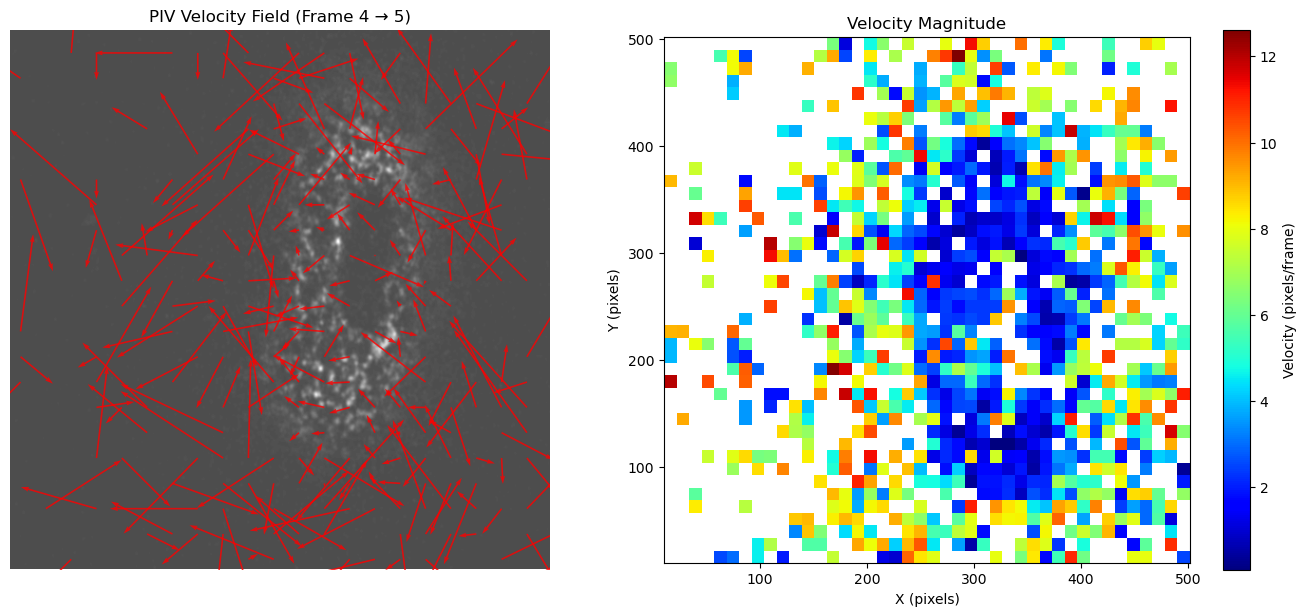

In [8]:
import matplotlib.pyplot as plt

# Select a frame to visualize
frame_idx = 4

# Get the images
frame_a = (rgb_stack[frame_idx][..., 0] * 255).astype(np.uint32)
frame_b = (rgb_stack[frame_idx+1][..., 0] * 255).astype(np.uint32)

# Calculate PIV
vel_x, vel_y, signal_to_noise = pyprocess.extended_search_area_piv(
    frame_a, frame_b,
    window_size=opiv_window_size,
    overlap=opiv_overlap,
    dt=opiv_dt,
    search_area_size=opiv_search_size,
    sig2noise_method='peak2peak'
)

# Get grid coordinates
x_grid, y_grid = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=opiv_search_size,
    overlap=opiv_overlap
)

# Validate
vel_x, vel_y, invalid_mask = validation.sig2noise_val(
    vel_x, vel_y, signal_to_noise, threshold=sig2noise_threshold
)

# Transform coordinates
x_grid, y_grid, vel_x, vel_y = tools.transform_coordinates(x_grid, y_grid, vel_x, vel_y)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Velocity vectors on image
ax1.imshow(frame_a, cmap='gray', alpha=0.7)
# Subsample for clearer visualization (show every 2nd vector)
skip = 2
ax1.quiver(x_grid[::skip, ::skip], y_grid[::skip, ::skip], 
           vel_x[::skip, ::skip], vel_y[::skip, ::skip],
           color='red', scale=50, width=0.003, alpha=0.8)
ax1.set_title(f'PIV Velocity Field (Frame {frame_idx} → {frame_idx+1})')
ax1.set_xlim(0, frame_a.shape[1])
ax1.set_ylim(frame_a.shape[0], 0)
ax1.axis('off')

# Right plot: Velocity magnitude
velocity_magnitude = np.sqrt(vel_x**2 + vel_y**2)
im = ax2.imshow(velocity_magnitude, cmap='jet', origin='lower', 
                extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()])
ax2.set_title('Velocity Magnitude')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Y (pixels)')
plt.colorbar(im, ax=ax2, label='Velocity (pixels/frame)')

plt.tight_layout()
plt.show()

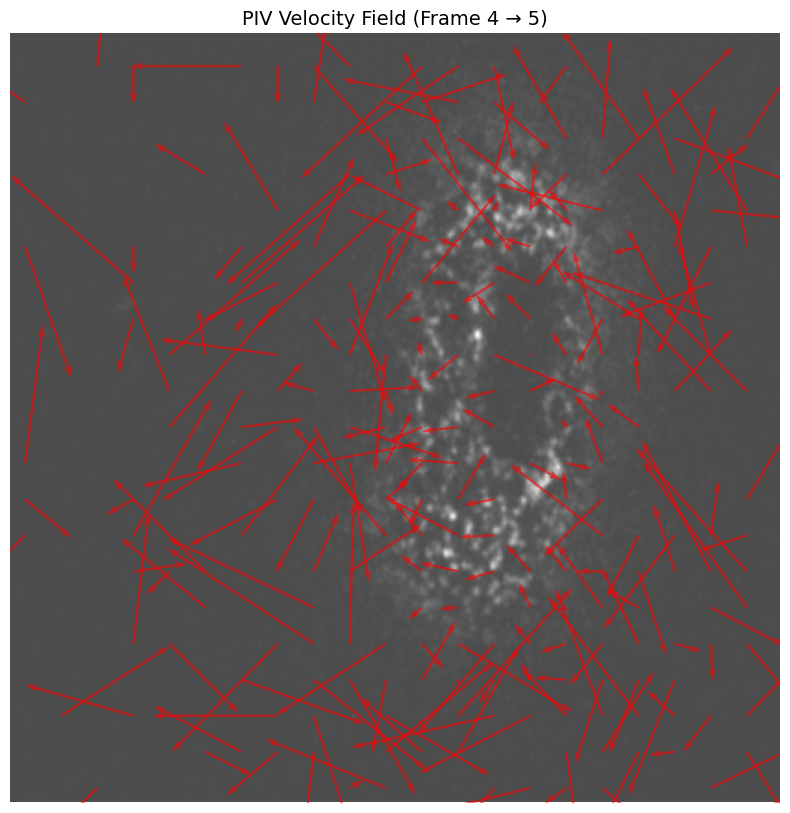

In [9]:
import matplotlib.pyplot as plt

# Select a frame to visualize
frame_idx = 4

# Get the images
frame_a = (rgb_stack[frame_idx][..., 0] * 255).astype(np.uint32)
frame_b = (rgb_stack[frame_idx+1][..., 0] * 255).astype(np.uint32)

# Calculate PIV
vel_x, vel_y, signal_to_noise = pyprocess.extended_search_area_piv(
    frame_a, frame_b,
    window_size=opiv_window_size,
    overlap=opiv_overlap,
    dt=opiv_dt,
    search_area_size=opiv_search_size,
    sig2noise_method='peak2peak'
)

# Get grid coordinates
x_grid, y_grid = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=opiv_search_size,
    overlap=opiv_overlap
)

# Validate
vel_x, vel_y, invalid_mask = validation.sig2noise_val(
    vel_x, vel_y, signal_to_noise, threshold=sig2noise_threshold
)

# Transform coordinates
x_grid, y_grid, vel_x, vel_y = tools.transform_coordinates(x_grid, y_grid, vel_x, vel_y)

# Create standalone visualization of velocity vectors
fig, ax = plt.subplots(figsize=(10, 10))

# Show the image
ax.imshow(frame_a, cmap='gray', alpha=0.7)

# Overlay velocity vectors (subsample for clearer visualization)
skip = 2
ax.quiver(x_grid[::skip, ::skip], y_grid[::skip, ::skip], 
          vel_x[::skip, ::skip], vel_y[::skip, ::skip],
          color='red', scale=50, width=0.003, alpha=0.6)

ax.set_title(f'PIV Velocity Field (Frame {frame_idx} → {frame_idx+1})', fontsize=14)
ax.set_xlim(0, frame_a.shape[1])
ax.set_ylim(frame_a.shape[0], 0)
ax.axis('off')

plt.savefig('piv_velocity_field.png', dpi=300)
plt.show()


In [10]:
# Animate annotated vs tracked points on the image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Prepare data
annotated_df = points.copy()
annotated_df = annotated_df[annotated_df['cut'] == False]
annotated_df = annotated_df[['frame', 'point_id', 'x', 'y']]

tracked_df.sort_values(['frame', 'point_id'], inplace=True)
annotated_df.sort_values(['frame', 'point_id'], inplace=True)

frames = sorted(tracked_df['frame'].unique())
point_ids = sorted(tracked_df['point_id'].unique())

fig = plt.figure(figsize=(6, 6))

def animate(i):
    plt.clf()
    frame = frames[i]
    
    # Update background image for current frame
    bg_img = rgb_stack[frame][..., 0]
    plt.imshow(bg_img, cmap='gray', alpha=0.7)
    
    # Annotated points
    ann_pts = annotated_df[annotated_df['frame'] == frame]
    plt.scatter(ann_pts['x'], ann_pts['y'], c='red', label='Annotated', s=60, edgecolors='black')
    
    # Tracked points
    trk_pts = tracked_df[tracked_df['frame'] == frame]
    plt.scatter(trk_pts['x'], trk_pts['y'], c='yellow', label='Tracked', s=60, edgecolors='black')
    
    plt.title(f'Frame {frame}')
    plt.legend(loc='upper right')
    plt.xlim(0, bg_img.shape[1])
    plt.ylim(bg_img.shape[0], 0)
    plt.axis('off')

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=300, repeat=False)

writer = animation.FFMpegWriter(fps=3)
ani.save('piv_tracking_animation.mp4', writer=writer, dpi=300)

html = HTML(ani.to_jshtml())
plt.close(fig)

html

/tmp/ipykernel_71263/2382922316.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_per_frame = merged.groupby('frame').apply(


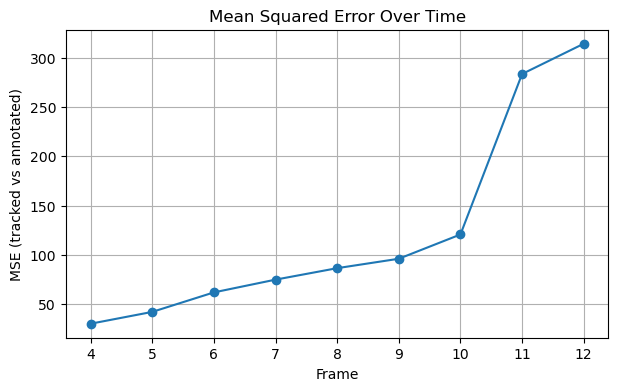

In [11]:
# Plot MSE over time
import matplotlib.pyplot as plt

# Merge tracked and annotated positions for each frame
annotated_df = points.copy()
annotated_df = annotated_df[['frame', 'point_id', 'x', 'y']]
merged = pd.merge(tracked_df, annotated_df, on=['frame', 'point_id'], suffixes=('_tracked', '_annotated'))

# Compute MSE for each frame
mse_per_frame = merged.groupby('frame').apply(
    lambda g: np.mean((g['x_tracked'] - g['x_annotated'])**2 + (g['y_tracked'] - g['y_annotated'])**2)
)

plt.figure(figsize=(7, 4))
plt.plot(mse_per_frame.index, mse_per_frame.values, marker='o')
plt.xlabel('Frame')
plt.ylabel('MSE (tracked vs annotated)')
plt.title('Mean Squared Error Over Time')
plt.grid(True)
plt.show()

## Track all cells

In [ ]:
# Loop over all cellids, run PIV tracking, and calculate overall MSE
points = Points.from_csv('../out/points.csv')

cellids = points['cell_id'].unique()
results = []
overall_mse = []
for idx, cellid in enumerate(cellids):
    # Filter points for this cellid
    cell_points = points.points_by_cell(cellid)
    if cell_points.empty:
        continue
    image_dir = '../data/ablation-czi/' + cellid + '.czi'
    with czi.CziFile(image_dir) as image_czi:
        image_data = image_czi.asarray()
    channel_red = np.squeeze(image_data[:, :, 0, :, :, :, :, :])
    channel_red_norm = channel_red / channel_red.max()
    num_slices, height, width = channel_red_norm.shape
    rgb_stack = np.zeros((num_slices, height, width, 2), dtype=np.float32)
    rgb_stack[..., 0] = channel_red_norm

    tracked_frames = cell_points['frame'].unique()
    tracked_points = []
    active_points = {}
    for frame_idx in tracked_frames:
        if tracked_frames[0] == frame_idx:
            pts_frame = cell_points[cell_points['frame'] == frame_idx]
            for _, row in pts_frame.iterrows():
                active_points[row['point_id']] = (row['x'], row['y'])
                # Store initial positions in tracked_points
                tracked_points.append({'frame': frame_idx, 'point_id': row['point_id'], 'x': row['x'], 'y': row['y']})
        frame_a = (rgb_stack[frame_idx][..., 0] * 255).astype(np.uint32)
        frame_b = (rgb_stack[frame_idx+1][..., 0] * 255).astype(np.uint32)
        vel_x, vel_y, signal_to_noise = pyprocess.extended_search_area_piv(
            frame_a, frame_b,
            window_size=opiv_window_size,
            overlap=opiv_overlap,
            dt=opiv_dt,
            search_area_size=opiv_search_size,
            sig2noise_method='peak2peak'
        )
        x_grid, y_grid = pyprocess.get_coordinates(
            image_size=frame_a.shape,
            search_area_size=opiv_search_size,
            overlap=opiv_overlap
        )
        vel_x, vel_y, invalid_mask = validation.sig2noise_val(
            vel_x, vel_y, signal_to_noise, threshold=sig2noise_threshold
        )
        x_grid, y_grid, vel_x, vel_y = tools.transform_coordinates(x_grid, y_grid, vel_x, vel_y)
        vel_x_interp = RegularGridInterpolator((y_grid[:,0], x_grid[0,:]), vel_x, bounds_error=False, fill_value=0)
        vel_y_interp = RegularGridInterpolator((y_grid[:,0], x_grid[0,:]), vel_y, bounds_error=False, fill_value=0)
        new_active_points = {}
        for pid, (x, y) in active_points.items():
            vx = vel_x_interp((y, x))
            vy = vel_y_interp((y, x))
            vx = np.nan_to_num(vx, nan=0.0)
            vy = np.nan_to_num(vy, nan=0.0)
            new_x = x + vx * opiv_dt
            new_y = y + vy * opiv_dt
            tracked_points.append({'frame': frame_idx+1, 'point_id': pid, 'x': new_x, 'y': new_y})
            new_active_points[pid] = (new_x, new_y)
        active_points = new_active_points
    tracked_df = pd.DataFrame(tracked_points)
    annotated_df = cell_points[['frame', 'point_id', 'x', 'y', 'cut']].copy()
    annotated_df.rename(columns={'x': 'x_ann', 'y': 'y_ann'}, inplace=True)
    
    # Use left merge to keep all annotated points, including cut points
    merged = pd.merge(annotated_df, tracked_df, on=['frame', 'point_id'], how='left')
    
    # For cut points, use annotated coordinates instead of tracked coordinates
    merged.loc[merged['cut'] == True, 'x'] = merged.loc[merged['cut'] == True, 'x_ann']
    merged.loc[merged['cut'] == True, 'y'] = merged.loc[merged['cut'] == True, 'y_ann']
    
    # Add cell_id to each row
    merged['cell_id'] = cellid
    
    # Keep only the required columns
    merged = merged[['cell_id', 'point_id', 'frame', 'x', 'y', 'cut']]
    
    results.append(merged)
    print(f'Progress {idx+1}/{len(cellids)} | Cell {cellid}')
    clear_output(wait=True)

results_df = pd.concat(results, ignore_index=True)
results_df

,cell_id,point_id,frame,x,y,cut
0,220530-E1_Out,0,3,368.000000,192.000000,False
1,220530-E1_Out,0,4,368.000000,192.000000,False
2,220530-E1_Out,0,5,368.000000,192.000000,False
3,220530-E1_Out,0,6,366.974841,191.820231,False
4,220530-E1_Out,0,7,366.974841,191.820231,False
...,...,...,...,...,...,...
11709,230429-E9_Out,1909,8,238.370950,243.838297,False
11710,230429-E9_Out,1909,9,238.370950,243.838297,False
11711,230429-E9_Out,1909,10,238.370950,243.838297,False
11712,230429-E9_Out,1910,4,237.000000,164.000000,True


In [ ]:
results_df.to_csv('../out/piv_points.csv', index=False)